# SC1015 Mini Project B124 Team 3
## By Toh Jia Jun Benjamin (U2221277C) and Yang Jerry

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import urllib
import math
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor

# Reading datasets and combining them

In [2]:
Data2012 = pd.read_csv('prices-mar-2012-to-dec-2014.csv')
Data2016 = pd.read_csv('prices-from-jan-2015-to-dec-2016.csv')
Data2017 = pd.read_csv('prices--jan-2017-onwards.csv')
Data = pd.concat([Data2012, Data2016, Data2017], ignore_index=True)

## Checking info of the data and removing considered unimportant data

In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169730 entries, 0 to 169729
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                169730 non-null  object 
 1   town                 169730 non-null  object 
 2   flat_type            169730 non-null  object 
 3   block                169730 non-null  object 
 4   street_name          169730 non-null  object 
 5   storey_range         169730 non-null  object 
 6   floor_area_sqm       169730 non-null  float64
 7   flat_model           169730 non-null  object 
 8   lease_commence_date  169730 non-null  int64  
 9   resale_price         169730 non-null  float64
 10  remaining_lease      117527 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 14.2+ MB


In [4]:
display(Data)

month        town  flat_type block        street_name storey_range  \
0       2012-03  ANG MO KIO     2 ROOM   172   ANG MO KIO AVE 4     06 TO 10   
1       2012-03  ANG MO KIO     2 ROOM   510   ANG MO KIO AVE 8     01 TO 05   
2       2012-03  ANG MO KIO     3 ROOM   610   ANG MO KIO AVE 4     06 TO 10   
3       2012-03  ANG MO KIO     3 ROOM   474  ANG MO KIO AVE 10     01 TO 05   
4       2012-03  ANG MO KIO     3 ROOM   604   ANG MO KIO AVE 5     06 TO 10   
...         ...         ...        ...   ...                ...          ...   
169725  2020-09      YISHUN     5 ROOM   716       YISHUN ST 71     07 TO 09   
169726  2020-09      YISHUN     5 ROOM   760       YISHUN ST 72     07 TO 09   
169727  2020-09      YISHUN     5 ROOM   835       YISHUN ST 81     04 TO 06   
169728  2020-09      YISHUN  EXECUTIVE   791       YISHUN AVE 2     04 TO 06   
169729  2020-09      YISHUN  EXECUTIVE   387     YISHUN RING RD     04 TO 06   

        floor_area_sqm      flat_model  lease_commence_date  resale_price  \
0                 45.0        Improved                 1986      250000.0   
1                 44.0        Improved                 1980      265000.0   
2                 68.0  New Generation                 1980      315000.0   
3                 67.0  New Generation                 1984      320000.0   
4                 67.0  New Generation                 1980      321000.0   
...                ...             ...                  ...           ...   
169725           131.0        Improved                 1987      440000.0   
169726           122.0        Improved                 1987      458000.0   
169727           122.0        Improved                 1987      490000.0   
169728           146.0      Maisonette                 1987      558000.0   
169729           146.0      Maisonette                 1988      555000.0   

           remaining_lease  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
169725  66 years 03 months  
169726  65 years 06 months  
169727  66 years 04 months  
169728  66 years 03 months  
169729  66 years 09 months  

[169730 rows x 11 columns]

In [5]:
print(Data.flat_model.unique())

['Improved' 'New Generation' 'Standard' 'Model A' 'Simplified'
 'Premium Apartment' 'Maisonette' 'Model A-Maisonette' 'Apartment'
 'Adjoined flat' 'Multi Generation' 'Model A2' 'Terrace'
 'Improved-Maisonette' 'Premium Maisonette' 'DBSS' 'Type S1' 'Type S2'
 'Premium Apartment Loft' '2-room']


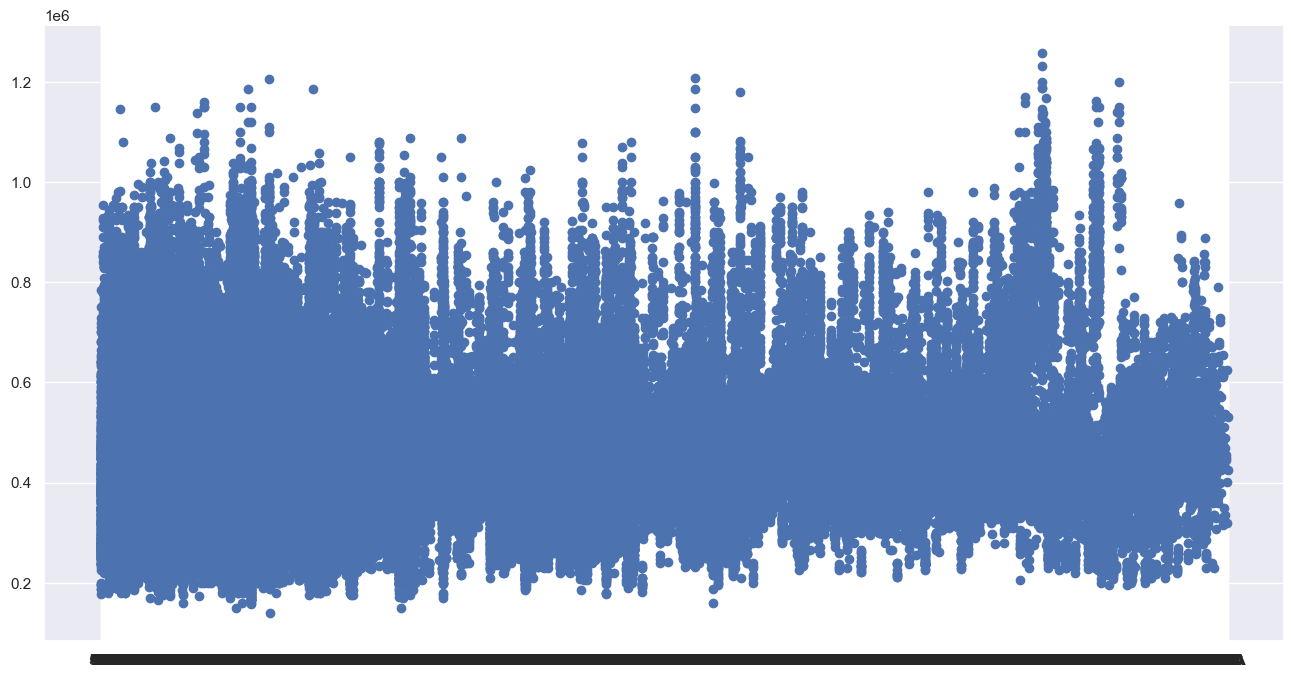

In [6]:
f = plt.figure(figsize=(16, 8))
plt.scatter(Data['block'], Data['resale_price'])

plt.show()

In [62]:
f = plt.figure(figsize=(20, 8))
plt.scatter(Data['storey_range'], Data['resale_price'])
plt.show()

In [8]:
f = plt.figure(figsize=(32, 8))
plt.scatter(Data['flat_model'], Data['resale_price'])
plt.show()

In [9]:
Filter1 = Data.drop(columns = ['block','street_name','storey_range','flat_model',
                            'remaining_lease'])

We chose to drop the above variables as:
1) block number: Does not have a strong relationship with resale price\
2) Storey Range: Obvious increase with the taller storeys but only for the very high up values so we decided to remove this variable.\
3) remaining lease: Closely related to the lease start year and it contains some NaN values so we decided to use lease start year\
4) flat model: Did not have enough information to analyse of the data (For Labelling) and link it to the price.

In [10]:
Filter1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169730 entries, 0 to 169729
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                169730 non-null  object 
 1   town                 169730 non-null  object 
 2   flat_type            169730 non-null  object 
 3   floor_area_sqm       169730 non-null  float64
 4   lease_commence_date  169730 non-null  int64  
 5   resale_price         169730 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 7.8+ MB


## Removing Outliers

In [11]:
def drop_outliers(df,columns):
    for col in columns:
        q1=df[columns].quantile(0.25)
        q3=df[columns].quantile(0.75)
        IQR=q3-q1
        not_outliers = df[~((df[columns]<(q1-1.5*IQR)) | (df[columns]>(q3+1.5*IQR))).any(axis=1)]
        return not_outliers

In [12]:
Filter1 = drop_outliers(Filter1,(['resale_price']))
Filter1

month        town  flat_type  floor_area_sqm  lease_commence_date  \
0       2012-03  ANG MO KIO     2 ROOM            45.0                 1986   
1       2012-03  ANG MO KIO     2 ROOM            44.0                 1980   
2       2012-03  ANG MO KIO     3 ROOM            68.0                 1980   
3       2012-03  ANG MO KIO     3 ROOM            67.0                 1984   
4       2012-03  ANG MO KIO     3 ROOM            67.0                 1980   
...         ...         ...        ...             ...                  ...   
169725  2020-09      YISHUN     5 ROOM           131.0                 1987   
169726  2020-09      YISHUN     5 ROOM           122.0                 1987   
169727  2020-09      YISHUN     5 ROOM           122.0                 1987   
169728  2020-09      YISHUN  EXECUTIVE           146.0                 1987   
169729  2020-09      YISHUN  EXECUTIVE           146.0                 1988   

        resale_price  
0           250000.0  
1           265000.0  
2           315000.0  
3           320000.0  
4           321000.0  
...              ...  
169725      440000.0  
169726      458000.0  
169727      490000.0  
169728      558000.0  
169729      555000.0  

[164008 rows x 6 columns]

## Grouping the data into years instead of month:

In [13]:
Filter1['year'] = Filter1['month'].str[:4]
Filter1['year'] = Filter1['year'].astype(str).astype(int)

Filter1

month        town  flat_type  floor_area_sqm  lease_commence_date  \
0       2012-03  ANG MO KIO     2 ROOM            45.0                 1986   
1       2012-03  ANG MO KIO     2 ROOM            44.0                 1980   
2       2012-03  ANG MO KIO     3 ROOM            68.0                 1980   
3       2012-03  ANG MO KIO     3 ROOM            67.0                 1984   
4       2012-03  ANG MO KIO     3 ROOM            67.0                 1980   
...         ...         ...        ...             ...                  ...   
169725  2020-09      YISHUN     5 ROOM           131.0                 1987   
169726  2020-09      YISHUN     5 ROOM           122.0                 1987   
169727  2020-09      YISHUN     5 ROOM           122.0                 1987   
169728  2020-09      YISHUN  EXECUTIVE           146.0                 1987   
169729  2020-09      YISHUN  EXECUTIVE           146.0                 1988   

        resale_price  year  
0           250000.0  2012  
1           265000.0  2012  
2           315000.0  2012  
3           320000.0  2012  
4           321000.0  2012  
...              ...   ...  
169725      440000.0  2020  
169726      458000.0  2020  
169727      490000.0  2020  
169728      558000.0  2020  
169729      555000.0  2020  

[164008 rows x 7 columns]

## Changing categorical information "flat_type" into numerical data through ordinal encoding with regards to size.
### Legends:
1 room flat --> 1\
2 room flat --> 2\
3 room flat --> 3\
4 room flat --> 4\
MultiGeneration flat --> 5\
5 room flat --> 6\
Executive flat --> 7

In [14]:

Filter2 = pd.DataFrame(Filter1)
Filter2['flat_type'] = Filter2['flat_type'].replace(['1 ROOM','2 ROOM','3 ROOM','4 ROOM', '5 ROOM','EXECUTIVE','MULTI-GENERATION'],[1,2,3,4,6,7,5])

In [15]:
Filter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164008 entries, 0 to 169729
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                164008 non-null  object 
 1   town                 164008 non-null  object 
 2   flat_type            164008 non-null  int64  
 3   floor_area_sqm       164008 non-null  float64
 4   lease_commence_date  164008 non-null  int64  
 5   resale_price         164008 non-null  float64
 6   year                 164008 non-null  int32  
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 9.4+ MB


In [16]:
cols = list(Filter2.columns.values)
cols

['month',
 'town',
 'flat_type',
 'floor_area_sqm',
 'lease_commence_date',
 'resale_price',
 'year']

In [17]:

Filter2 = Filter2[['resale_price', 'year', 'lease_commence_date' ,'floor_area_sqm', 'flat_type','town']]
cols = list(Filter2.columns.values)
cols

['resale_price',
 'year',
 'lease_commence_date',
 'floor_area_sqm',
 'flat_type',
 'town']

## Checking relation between the variables and salesprice:
### Checking Relations between numerical datas.

<AxesSubplot:>

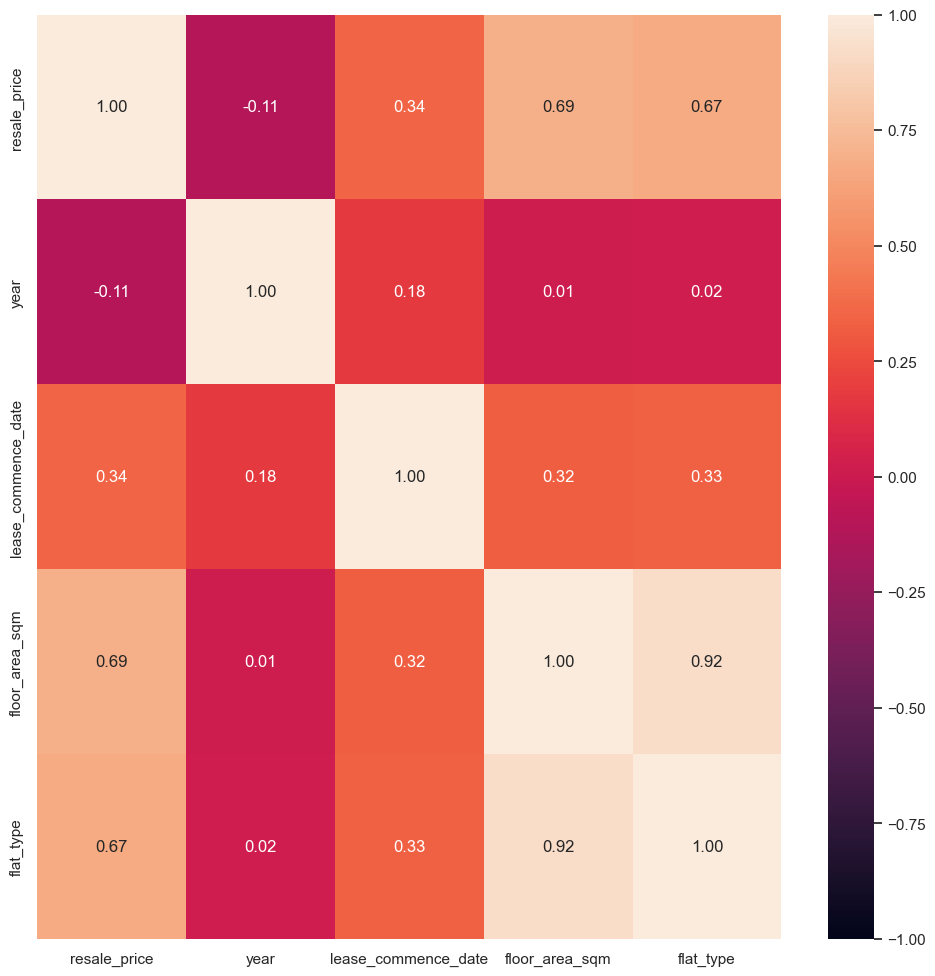

In [18]:
f = plt.figure(figsize=(12, 12))
sb.heatmap(Filter2.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

## Using One-hot Encoding to convert Location Data from categorical to Numerical Data

In [19]:
Location = pd.get_dummies(Filter2['town'])
# dropping extra column
LocData = Filter2['resale_price']
# concatation of independent variables and new cateorical variable.
LocData=pd.concat([LocData,Location],axis=1)
RegressionData = pd.concat([Filter2,Location],axis=1)
RegressionData = RegressionData.drop(columns = ['town'])
RegressionData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164008 entries, 0 to 169729
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   resale_price         164008 non-null  float64
 1   year                 164008 non-null  int32  
 2   lease_commence_date  164008 non-null  int64  
 3   floor_area_sqm       164008 non-null  float64
 4   flat_type            164008 non-null  int64  
 5   ANG MO KIO           164008 non-null  uint8  
 6   BEDOK                164008 non-null  uint8  
 7   BISHAN               164008 non-null  uint8  
 8   BUKIT BATOK          164008 non-null  uint8  
 9   BUKIT MERAH          164008 non-null  uint8  
 10  BUKIT PANJANG        164008 non-null  uint8  
 11  BUKIT TIMAH          164008 non-null  uint8  
 12  CENTRAL AREA         164008 non-null  uint8  
 13  CHOA CHU KANG        164008 non-null  uint8  
 14  CLEMENTI             164008 non-null  uint8  
 15  GEYLANG          

### Checking Relation of town and resale price

Text(0.5, 1.0, 'Price relation to town')

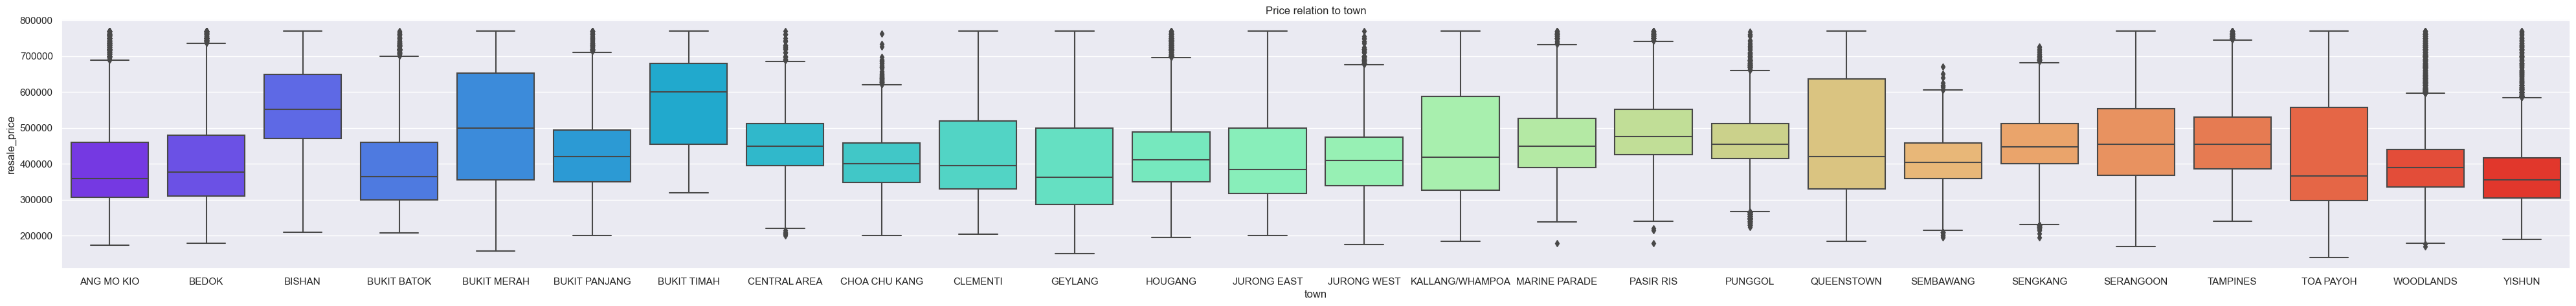

In [20]:
plt.figure(figsize=(50,5))
sb.boxplot(x='town',y='resale_price',data=Filter2, palette='rainbow')
plt.title("Price relation to town")

Text(0.5, 1.0, 'Resale Price relation to Year')

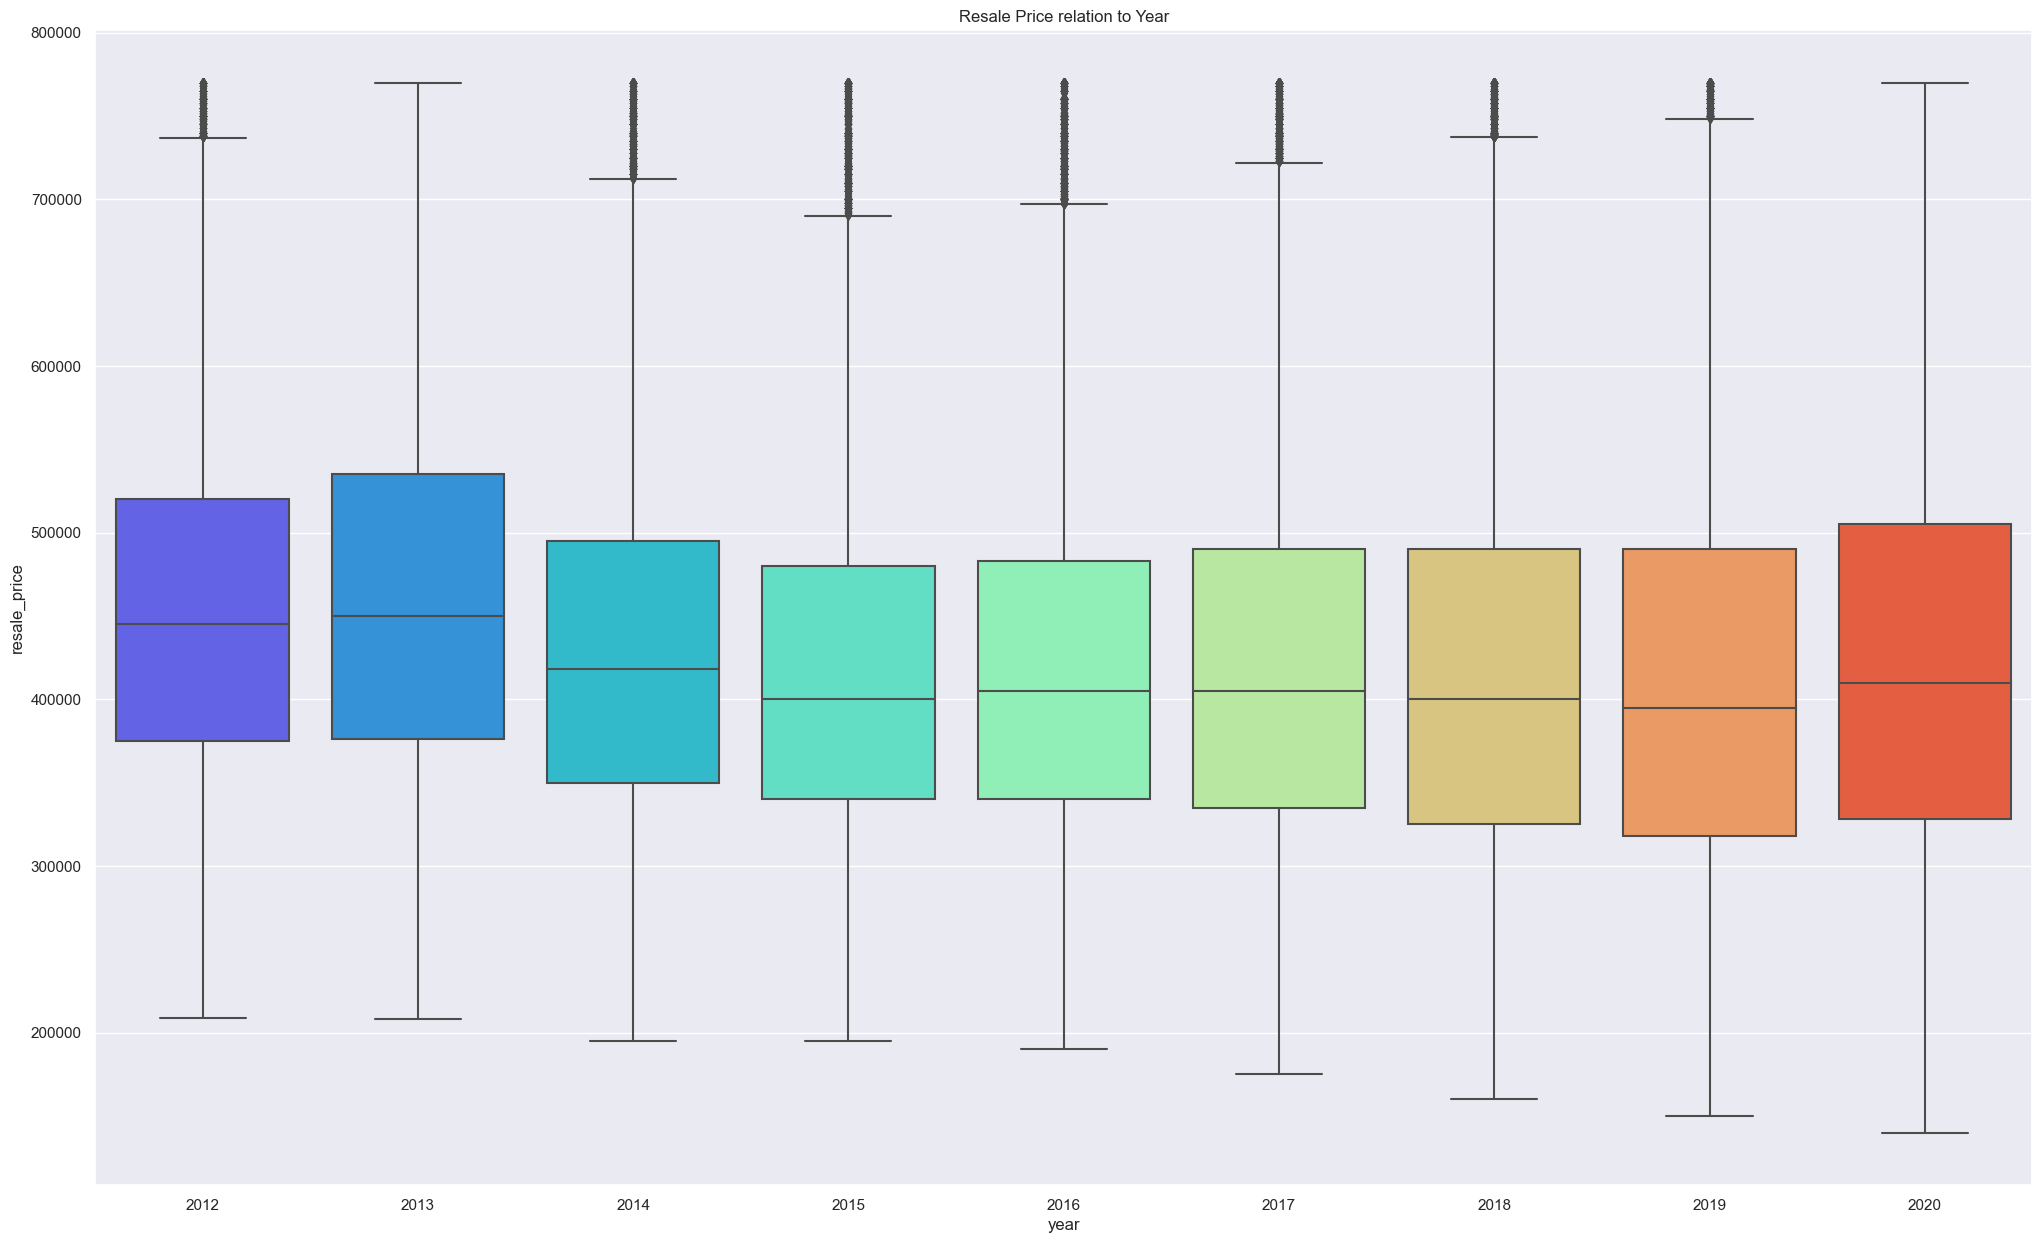

In [21]:
plt.figure(figsize=(25,15))
sb.boxplot(x='year',y='resale_price',data=Filter2, palette='rainbow')
plt.title("Resale Price relation to Year")

From the above box plot, it is seen that\
1)the minimum resale price is decreasing over the years\
2)the upper and lower quartile variates slightly\
3)the maximum resale price is around the same\
This may be due to aging of the housing, causing the resale price for older buildings to decrease and thus reducing the lower prices for the more recent years

<AxesSubplot:>

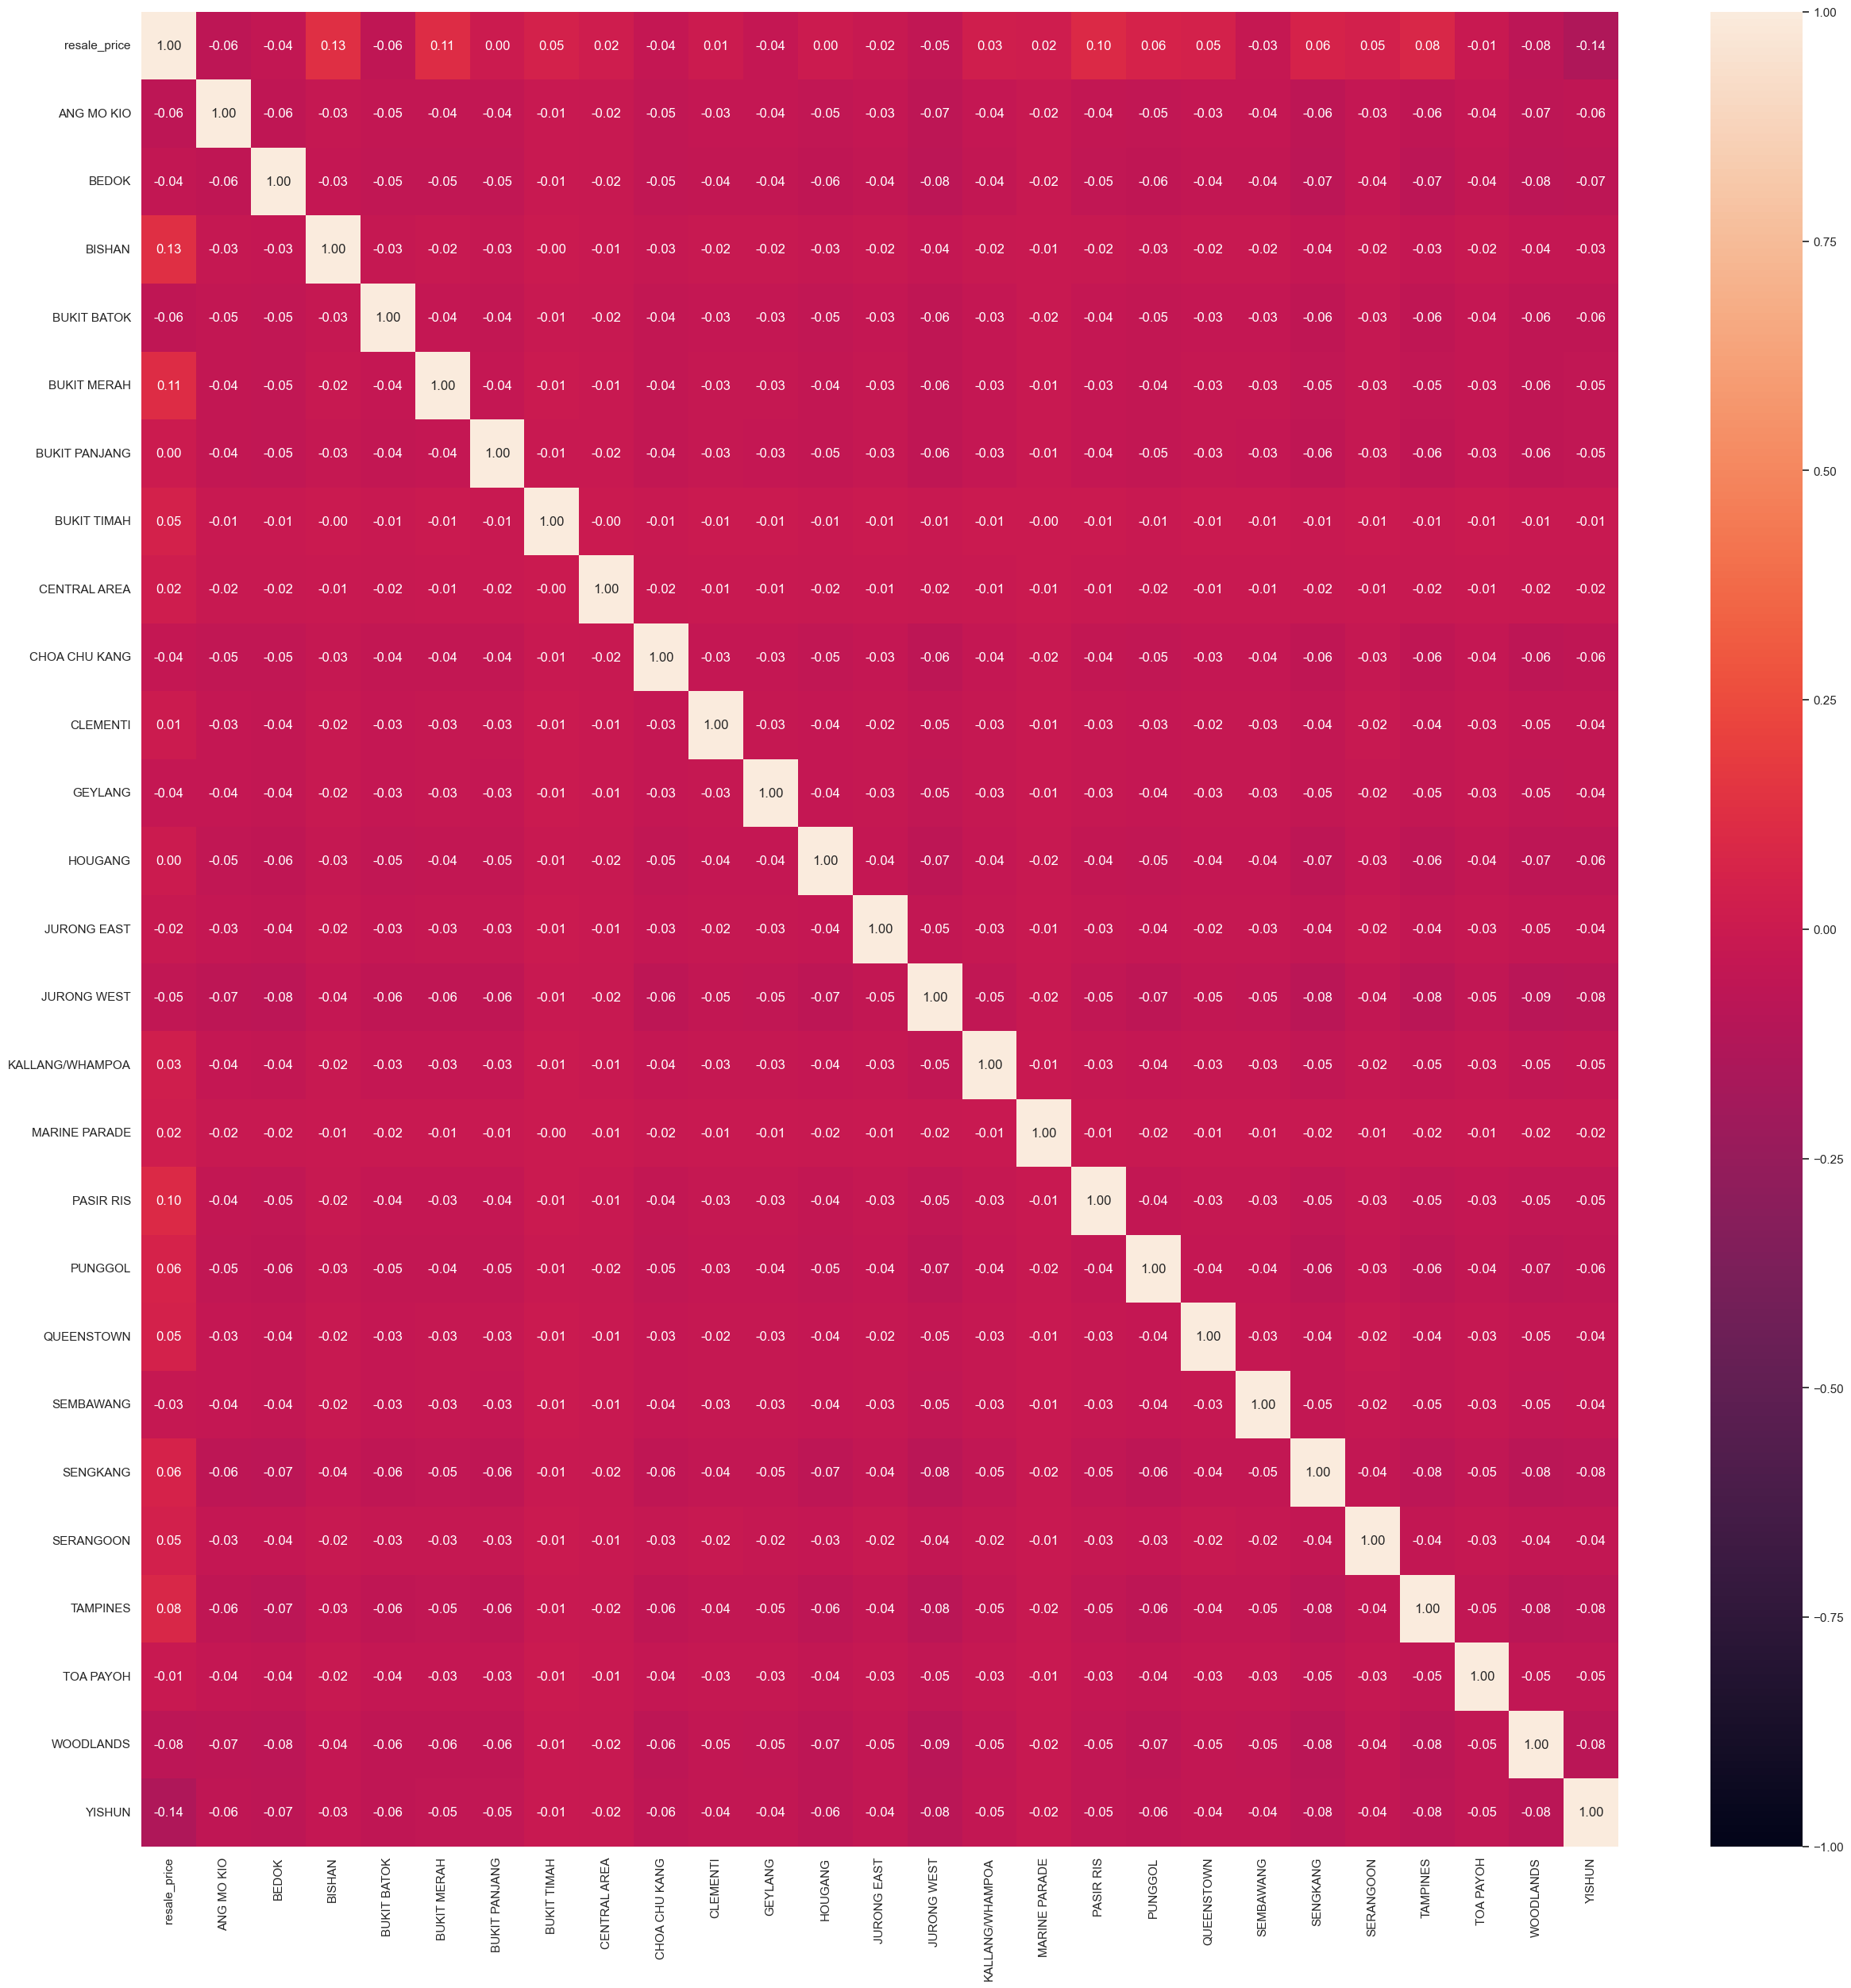

In [22]:

f = plt.figure(figsize=(30, 30))
sb.heatmap(LocData.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

There seems to be a relation between resale price and its location but it is not strongly related in the above heatmap

In [23]:
def GoodnessAndAccuracy(trainx, trainy,testy,model):
    predy = model.predict(trainx)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", model.score(trainx,trainy))
    print("\n")

    # Check the Goodness of Fit (on Test Data)
    print("Predicion of Accuracy of Model \tTest Dataset")
    print("Mean Squared Error (MSE) \t:", mean_squared_error(trainy, predy))
    print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(trainy, predy)))
    print("\n")
    return

In [24]:
def LinearModel(trainx,trainy):
    model = LinearRegression().fit(trainx, trainy)
    print('Intercept \t: b = ', model.intercept_)
    print('Coefficients \t: a = ', model.coef_)
    regline_x = trainx
    regline_y = model.intercept_ + model.coef_ * trainx

    # Plot the Linear Regression line
    f = plt.figure(figsize=(16, 8))
    plt.scatter(trainx, trainy)
    plt.plot(regline_x, regline_y, 'r-', linewidth = 3 )
    plt.show()
    return model

In [25]:
X, y = pd.DataFrame(RegressionData.iloc[:, 1:]), RegressionData['resale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=50
)
display(X_train)
display(y_train)
display(X_train.shape, X_test.shape)

year  lease_commence_date  floor_area_sqm  flat_type  ANG MO KIO  \
168245  2020                 2014            93.0          4           0   
116425  2018                 1998           100.0          4           0   
105370  2017                 2002           110.0          6           0   
53622   2015                 1985            69.0          3           0   
48846   2014                 1992           104.0          4           0   
...      ...                  ...             ...        ...         ...   
127089  2018                 1995           143.0          7           0   
60785   2015                 1985            67.0          3           0   
159007  2020                 2015            92.0          4           0   
106977  2017                 1987            74.0          3           0   
150056  2019                 1988           131.0          6           0   

        BEDOK  BISHAN  BUKIT BATOK  BUKIT MERAH  BUKIT PANJANG  ...  \
168245      0       0            0            0              0  ...   
116425      0       0            0            0              0  ...   
105370      0       0            0            0              0  ...   
53622       0       0            1            0              0  ...   
48846       0       0            0            0              0  ...   
...       ...     ...          ...          ...            ...  ...   
127089      0       0            0            0              0  ...   
60785       0       0            0            0              0  ...   
159007      0       0            0            0              0  ...   
106977      0       0            0            0              0  ...   
150056      0       1            0            0              0  ...   

        PASIR RIS  PUNGGOL  QUEENSTOWN  SEMBAWANG  SENGKANG  SERANGOON  \
168245          0        0           0          0         0          0   
116425          0        0           0          0         0          0   
105370          0        0           0          0         0          0   
53622           0        0           0          0         0          0   
48846           1        0           0          0         0          0   
...           ...      ...         ...        ...       ...        ...   
127089          0        0           0          0         0          0   
60785           0        0           0          0         0          0   
159007          0        0           0          0         0          0   
106977          0        0           0          0         0          0   
150056          0        0           0          0         0          0   

        TAMPINES  TOA PAYOH  WOODLANDS  YISHUN  
168245         0          0          0       0  
116425         0          0          0       0  
105370         0          0          0       0  
53622          0          0          0       0  
48846          0          0          0       0  
...          ...        ...        ...     ...  
127089         0          0          0       0  
60785          0          0          0       1  
159007         0          0          0       1  
106977         0          0          0       0  
150056         0          0          0       0  

[131206 rows x 30 columns]

168245    450500.0
116425    375000.0
105370    467000.0
53622     295800.0
48846     440000.0
            ...   
127089    527000.0
60785     308000.0
159007    440888.0
106977    315000.0
150056    755000.0
Name: resale_price, Length: 131206, dtype: float64

(131206, 30)

(32802, 30)

Intercept 	: b =  101503.9118860673
Coefficients 	: a =  [3426.38914659]


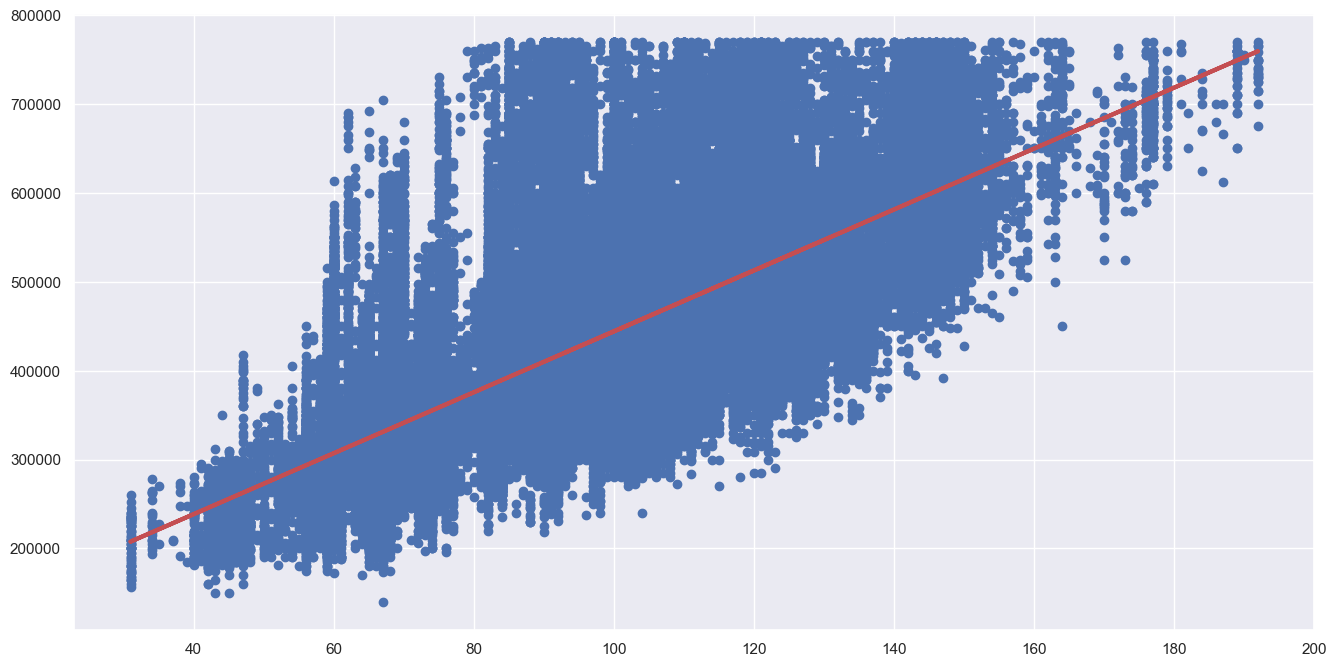

For simple Linear Regression based on floor area:

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.47774433369036917


Predicion of Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 7466368732.978347
Root Mean Squared Error (RMSE) 	: 86408.15200534233




In [26]:
LinearReg = LinearModel(pd.DataFrame(X_train['floor_area_sqm']),y_train)
print("For simple Linear Regression based on floor area:\n")
GoodnessAndAccuracy(pd.DataFrame(X_train['floor_area_sqm']),y_train,y_test,LinearReg)

# Gradient Boosting Regression

In [27]:
# X, y = pd.DataFrame(RegressionData.iloc[:, 1:]), RegressionData['resale_price']
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=50
#)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_split": 3,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [29]:
GBreg = ensemble.GradientBoostingRegressor(**params)
GBreg.fit(X_train, y_train)



GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_split=3,
                          n_estimators=500)

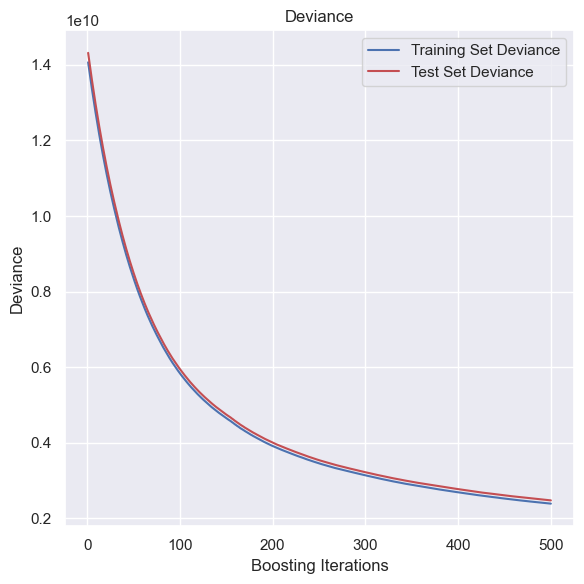

In [30]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(GBreg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    GBreg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

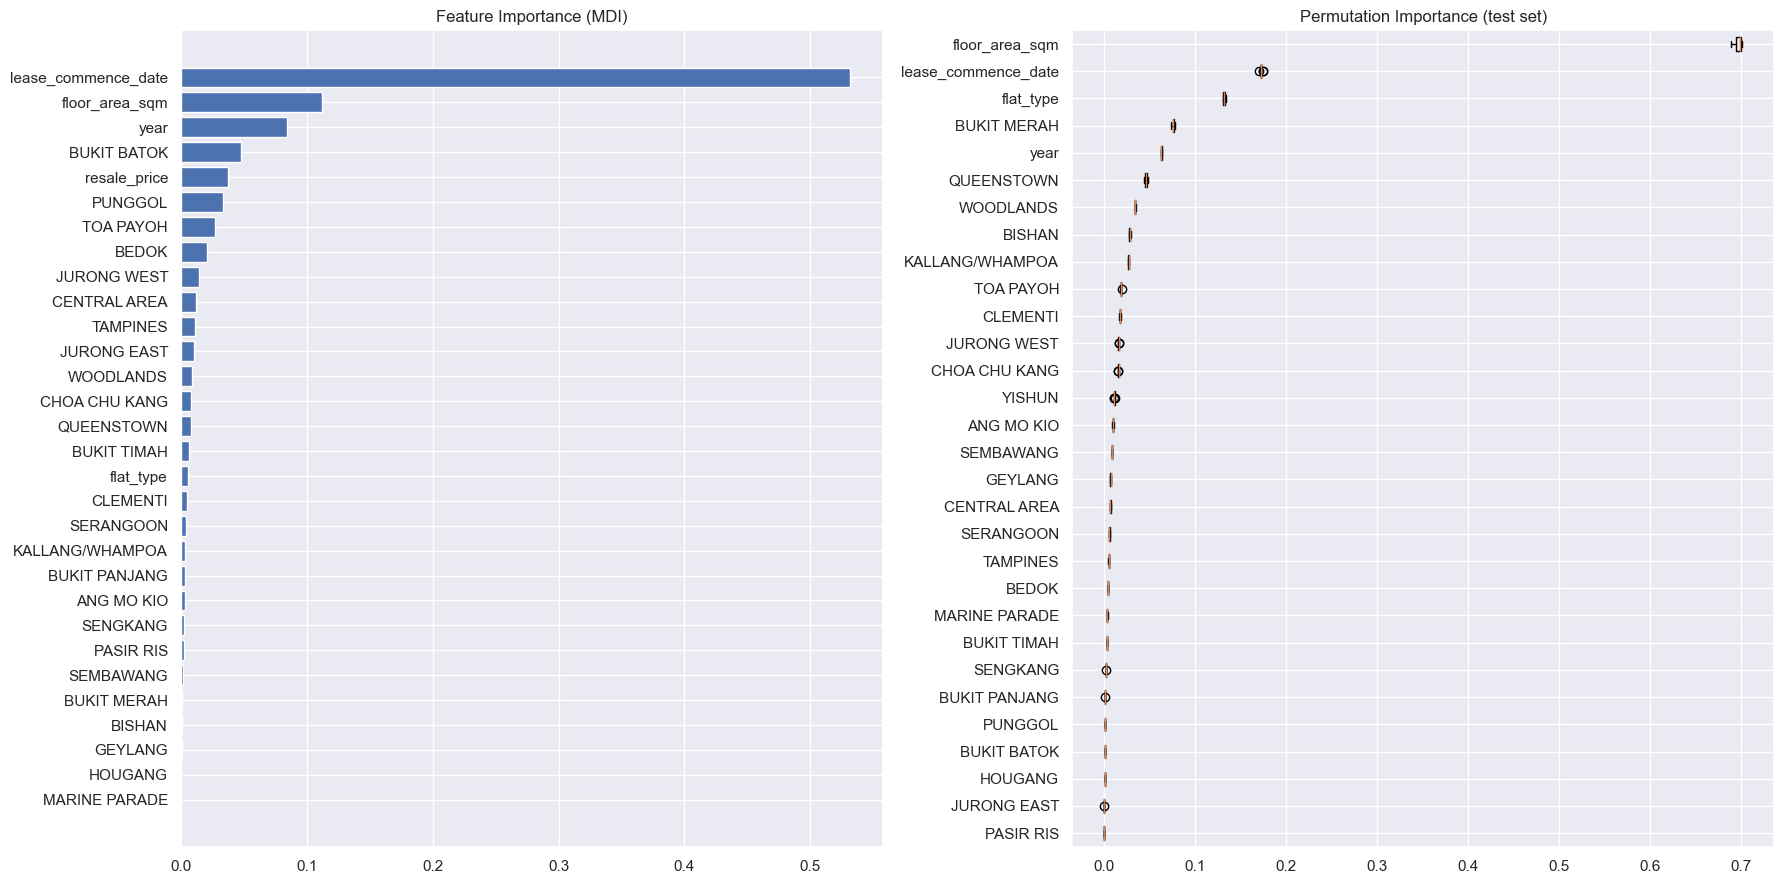

In [31]:
feature_importance = GBreg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(RegressionData.columns.values)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    GBreg, X_test, y_test, n_repeats=10, random_state=50, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns.values)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [32]:
est = HistGradientBoostingRegressor().fit(X, y)
est.score(X, y)

0.9003166052024886

In [33]:
score=r2_score(y_test, GBreg.predict(X_test))

print('r2 score is ',score)
mse = mean_squared_error(y_test, GBreg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print("The root mean squared error (MSE) on test set: {:.4f}".format(rmse))

r2 score is  0.8290899232406146
The mean squared error (MSE) on test set: 2478227057.8761
The root mean squared error (MSE) on test set: 49781.7944


In [58]:
params2 = {
    "n_estimators": 1000,
    "max_depth": 10,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
GBreg1000 = ensemble.GradientBoostingRegressor(**params2)
GBreg1000.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000)

In [59]:
test_score = np.zeros((params2["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(GBreg1000.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params2["n_estimators"]) + 1,
    GBreg1000.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params2["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [60]:
feature_importance = GBreg1000.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(RegressionData.columns.values)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    GBreg1000, X_test, y_test, n_repeats=10, random_state=50, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns.values)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [61]:
score=r2_score(y_test, GBreg1000.predict(X_test))

print('r2 score is ',score)
mse = mean_squared_error(y_test, GBreg1000.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print("The root mean squared error (MSE) on test set: {:.4f}".format(rmse))

r2 score is  0.9254970419974113
The mean squared error (MSE) on test set: 1080306380.4936
The root mean squared error (MSE) on test set: 32868.0146


### Multiple Linear Regression:

In [38]:
#df = pd.DataFrame(train)

#x = df[['flat_type' ,'floor_area_sqm' ,'lease_commence_date' ,'year']]
#y = df['resale_price']
 
# with sklearn
MultipleLR = LinearRegression()
MultipleLR.fit(X_train, y_train)

print('Intercept: \n', MultipleLR.intercept_)
print('Coefficients: \n', MultipleLR.coef_)

# with statsmodels
X_MLR = sm.add_constant(X_train) # adding a constant
 
MLRmodel = sm.OLS(y_train, X_MLR).fit() # ordinary least squares
predictions = MLRmodel.predict(X_MLR) 
 
print_model = MLRmodel.summary()
print(print_model)

Intercept: 
 8015694.570735018
Coefficients: 
 [  -8288.78770685    4414.97273318    3431.09151908    9074.56622974
   27942.79453235   11731.26187706   87477.76407708  -47519.3416041
  113325.63302095  -91256.33745229  168956.19409594  131222.67615909
 -132932.25390568   60694.602259     44514.13665748  -47035.27167262
  -28854.432392    -91805.54441421   72228.36860078  143590.50220242
  -77248.13420974  -83466.96306556  122107.17867945 -143152.24801425
  -91365.19639868   14142.88934492  -22139.03440016   59033.47949436
 -127295.97893859  -72896.74453248]
                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                 1.737e+04
Date:                Thu, 13 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:34:56   

In [39]:
x_MLR = sm.add_constant(X_test)
y_prediction = MLRmodel.predict(x_MLR)
y_MLR = y_test

MLscore=r2_score(y_test,y_prediction)
print('r2 score is ',MLscore)
print('mean_sqrd_error is==',mean_squared_error(y_MLR,y_prediction))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_MLR,y_prediction)))

r2 score is  0.7929748003695756
mean_sqrd_error is== 3001902878.4862804
root_mean_squared error of is== 54789.62382136129


## Random Forest Regression:

train_features, test_features, train_labels, test_labels
labels = y, features = x

In [40]:
xlist = list(X_train.columns)
xlist

['year',
 'lease_commence_date',
 'floor_area_sqm',
 'flat_type',
 'ANG MO KIO',
 'BEDOK',
 'BISHAN',
 'BUKIT BATOK',
 'BUKIT MERAH',
 'BUKIT PANJANG',
 'BUKIT TIMAH',
 'CENTRAL AREA',
 'CHOA CHU KANG',
 'CLEMENTI',
 'GEYLANG',
 'HOUGANG',
 'JURONG EAST',
 'JURONG WEST',
 'KALLANG/WHAMPOA',
 'MARINE PARADE',
 'PASIR RIS',
 'PUNGGOL',
 'QUEENSTOWN',
 'SEMBAWANG',
 'SENGKANG',
 'SERANGOON',
 'TAMPINES',
 'TOA PAYOH',
 'WOODLANDS',
 'YISHUN']

In [41]:
xtrain = np.array(X_train)
ytrain = np.array(y_train)
xtest = np.array(X_test)
ytest = np.array(y_test)

In [42]:
# The baseline predictions are the 
#baseline_preds = X_test[:, y_test]
baseline_preds = LinearReg.predict(pd.DataFrame(X_test['floor_area_sqm']))
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
GB_errors = abs(GBreg.predict(X_test) - y_test)
MLR_errors = abs(MLRmodel.predict(x_MLR) - y_test)
print('Average baseline error(Linear Regression with House area): $', round(np.mean(baseline_errors), 2))
print('Average baseline error(Gradient Boost): $', round(np.mean(GB_errors), 2))
print('Average baseline error(Multiple Linear Regression): $', round(np.mean(MLR_errors), 2))

Average baseline error(Linear Regression with House area): $ 64494.38
Average baseline error(Gradient Boost): $ 36963.87
Average baseline error(Multiple Linear Regression): $ 42001.02


In [43]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(xtrain,ytrain);

In [44]:
# Use the forest's predict method on the test data
predictions = rf.predict(xtest)
# Calculate the absolute errors
errors = abs(predictions - ytest)
# Print out the mean absolute error (mae)
print('Mean Absolute Error: $', round(np.mean(errors), 2))


Mean Absolute Error: $ 23467.6


In [45]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / ytest)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.53 %.


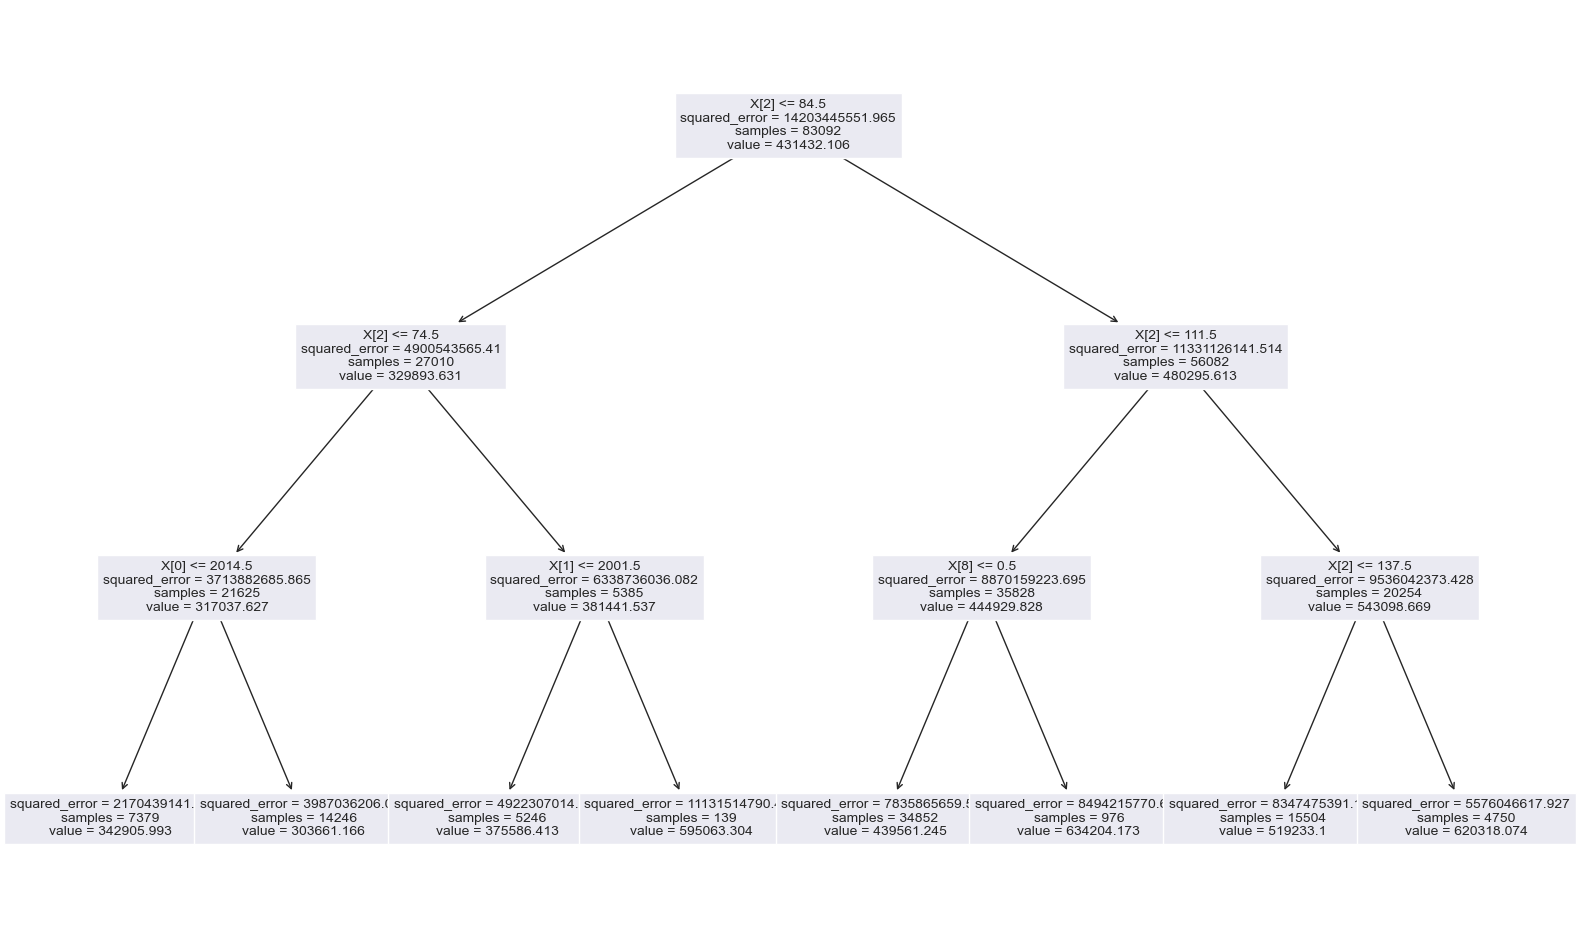

In [46]:
from sklearn import tree

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(xtrain, ytrain)
# Extract the small tree
tree_small = rf_small.estimators_[5]
plt.figure(figsize=(20,12))  # set plot size (denoted in inches)
tree.plot_tree(tree_small, fontsize=10)
plt.show()


In [47]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(xlist, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: floor_area_sqm       Importance: 0.56
Variable: lease_commence_date  Importance: 0.1
Variable: year                 Importance: 0.05
Variable: BUKIT MERAH          Importance: 0.04
Variable: QUEENSTOWN           Importance: 0.03
Variable: flat_type            Importance: 0.02
Variable: BISHAN               Importance: 0.02
Variable: KALLANG/WHAMPOA      Importance: 0.02
Variable: TOA PAYOH            Importance: 0.02
Variable: WOODLANDS            Importance: 0.02
Variable: ANG MO KIO           Importance: 0.01
Variable: BEDOK                Importance: 0.01
Variable: CENTRAL AREA         Importance: 0.01
Variable: CHOA CHU KANG        Importance: 0.01
Variable: CLEMENTI             Importance: 0.01
Variable: GEYLANG              Importance: 0.01
Variable: JURONG WEST          Importance: 0.01
Variable: TAMPINES             Importance: 0.01
Variable: YISHUN               Importance: 0.01
Variable: BUKIT BATOK          Importance: 0.0
Variable: BUKIT PANJANG        Importance:

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [xlist.index('floor_area_sqm'), xlist.index('lease_commence_date')]
train_important = xtrain[:, important_indices]
test_important = xtest[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, ytrain)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - ytest)
# Display the performance metrics
print('Mean Absolute Error: $', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / ytest))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

In [57]:
rf5 = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf5.fit(xtrain,ytrain);
predictions = rf5.predict(xtest)
# Calculate the absolute errors
errors = abs(predictions - ytest)
# Print out the mean absolute error (mae)
print('Mean Absolute Error: $', round(np.mean(errors), 2))
mape = 100 * (errors / ytest)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: $ 23470.2
Accuracy: 94.53 %.


Difference between the Models:
Reducing n-estimators lowers the Mean Absolute Error slightly but not very significant.
Similar to the Gradient Boosting Model, After reaching a saturation point, the error and accuracy does not have significant changes

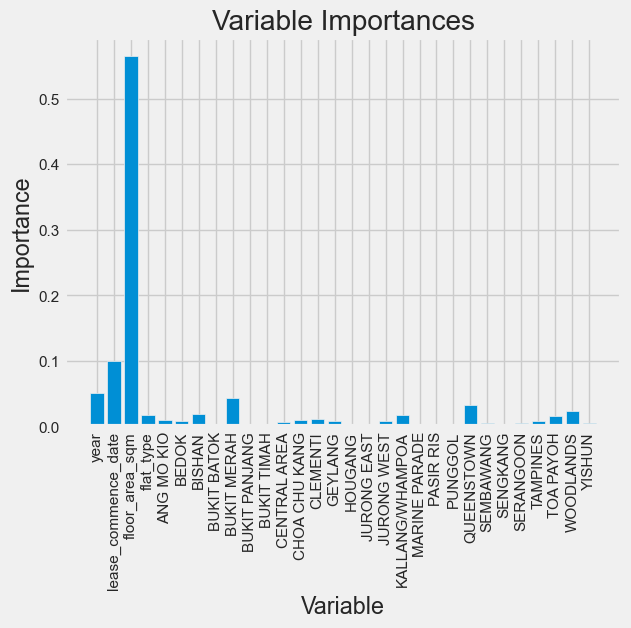

In [49]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, xlist, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [50]:
score=r2_score(y_test, rf.predict(xtest))

print('r2 score is ',score)
mse = mean_squared_error(y_test, rf.predict(xtest))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print("The root mean squared error (MSE) on test set: {:.4f}".format(rmse))

r2 score is  0.9274639026065825
The mean squared error (MSE) on test set: 1051786545.5422
The root mean squared error (MSE) on test set: 32431.2588


### Compilation of Score and MSE

In [51]:
print('For Random Tree Regression:')
RTRscore=r2_score(y_test, rf.predict(xtest))
print('r2 score is ',score)
RTRmse = mean_squared_error(y_test, rf.predict(xtest))
print("The mean squared error (MSE) on test set: {:.4f}".format(RTRmse))
RTRrmse = math.sqrt(RTRmse)
print("The root mean squared error (MSE) on test set: {:.4f}".format(RTRrmse))

For Random Tree Regression:
r2 score is  0.9274639026065825
The mean squared error (MSE) on test set: 1051786545.5422
The root mean squared error (MSE) on test set: 32431.2588


In [52]:
print("For simple Linear Regression based on floor area:\n")
GoodnessAndAccuracy(pd.DataFrame(X_train['floor_area_sqm']),y_train,y_test,LinearReg)

For simple Linear Regression based on floor area:

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.4772106141932164


Predicion of Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 7448011027.779652
Root Mean Squared Error (RMSE) 	: 86301.85993233084




In [53]:
print('For Gradient Boosting Regression:')
GBscore=r2_score(y_test, GBreg.predict(X_test))

print('r2 score is ',score)
GBmse = mean_squared_error(y_test, GBreg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(GBmse))
GBrmse = math.sqrt(GBmse)
print("The root mean squared error (MSE) on test set: {:.4f}".format(GBrmse))

For Gradient Boosting Regression:
r2 score is  0.9274639026065825
The mean squared error (MSE) on test set: 2478227057.8761
The root mean squared error (MSE) on test set: 49781.7944


In [54]:
print('For Multiple Linear Regression:')
y_prediction = MLRmodel.predict(x_MLR)
y_MLR = y_test

MLscore=r2_score(y_test,y_prediction)
print('r2 score is ',MLscore)
print('mean_sqrd_error is :',mean_squared_error(y_MLR,y_prediction))
print('root_mean_squared error of is :',np.sqrt(mean_squared_error(y_MLR,y_prediction)))

For Multiple Linear Regression:
r2 score is  0.7929748003695756
mean_sqrd_error is : 3001902878.4862804
root_mean_squared error of is : 54789.62382136129


In [55]:
print('Average baseline error(Linear Regression with House area): $', round(np.mean(baseline_errors), 2))
print('Average baseline error(Gradient Boost): $', round(np.mean(GB_errors), 2))
print('Average baseline error(Multiple Linear Regression): $', round(np.mean(MLR_errors), 2))
predictions = rf.predict(xtest)
# Calculate the absolute errors
errors = abs(predictions - ytest)
print('Average baseline error(Random Forest Regression): $', round(np.mean(errors), 2))

Average baseline error(Linear Regression with House area): $ 64494.38
Average baseline error(Gradient Boost): $ 36963.87
Average baseline error(Multiple Linear Regression): $ 42001.02
Average baseline error(Random Forest Regression): $ 23467.6
